# Output Visuals (Analysis Artifacts)
Load events/metrics produced by `analysis_pipeline.py` and visualize them.


In [1]:
from pathlib import Path
import sys
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

cwd = Path.cwd()
candidates = [cwd, cwd.parent, cwd.parent.parent]
ROOT = next((p for p in candidates if (p / "analysis").exists()), cwd)
sys.path.insert(0, str(ROOT))

from analysis.src.analysis_pipeline import load_frames


In [2]:
run_out = ROOT / "analysis" / "outputs" / "synth_run_0001"   # change as needed
events_path = run_out / "events.json"
metrics_path = run_out / "metrics.json"

events = json.loads(events_path.read_text()) if events_path.exists() else []
metrics = json.loads(metrics_path.read_text()) if metrics_path.exists() else {}

len(events), metrics


(1,
 {'total_duration_s': 10.0,
  'active_motion_duration_s': 9.933333333333334,
  'active_fraction': 0.9933333333333334,
  'peak_speed': 2.4832450063142324,
  'mean_speed': 0.36610619385792353,
  'motion_event_count': 1})

In [3]:
metrics_df = pd.DataFrame([metrics]).T
metrics_df.columns = ["value"]
metrics_df


,value
total_duration_s,10.000000
active_motion_duration_s,9.933333
active_fraction,0.993333
peak_speed,2.483245
mean_speed,0.366106
motion_event_count,1.000000


In [4]:
ev_df = pd.DataFrame(events)
if len(ev_df) > 0:
    ev_df["duration_s"] = ev_df["t_end"] - ev_df["t_start"]
ev_df


,event_type,t_start,t_end,confidence,meta,duration_s
0,tool_motion,0.066667,10.0,1.0,"{'tool_id': 'tool0', 'tool_type': 'scalpel_like'}",9.933333


In [5]:
# This assumes the corresponding input is still available (edit if your run differs)
input_path = ROOT / "analysis" / "data" / "samples" / "synth_run_0001" / "frames.json"
frames = load_frames(str(input_path))

t = np.asarray([fr.t for fr in frames], dtype=float)
p = np.stack([fr.tool.pose.p() for fr in frames], axis=0)

dt = np.diff(t)
dp = np.diff(p, axis=0)
speed = np.zeros(len(t), dtype=float)
safe_dt = np.where(dt <= 1e-9, np.nan, dt)
inst = np.linalg.norm(dp, axis=1) / safe_dt
inst = np.where(np.isfinite(inst), inst, 0.0)
speed[1:] = inst


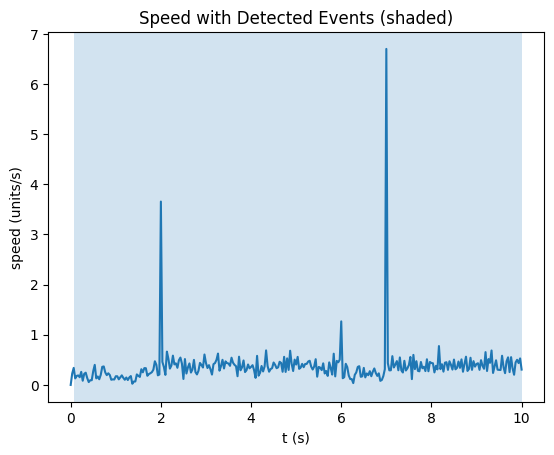

In [6]:
plt.figure()
plt.plot(t, speed, label="speed")

for ev in events:
    plt.gca().axvspan(ev["t_start"], ev["t_end"], alpha=0.2)

plt.xlabel("t (s)")
plt.ylabel("speed (units/s)")
plt.title("Speed with Detected Events (shaded)")
plt.show()


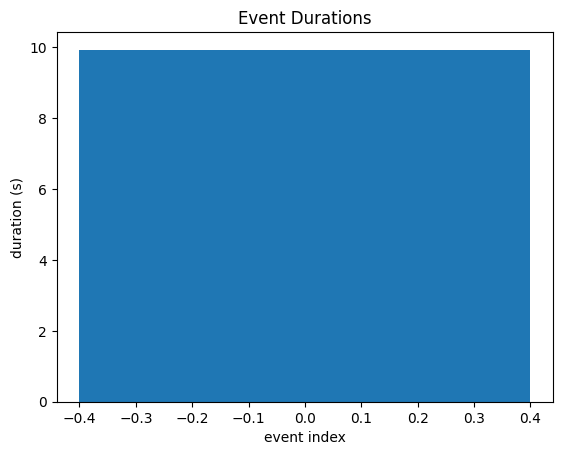

In [7]:
if len(ev_df) == 0:
    print("No events found.")
else:
    plt.figure()
    plt.bar(range(len(ev_df)), ev_df["duration_s"].to_numpy())
    plt.xlabel("event index")
    plt.ylabel("duration (s)")
    plt.title("Event Durations")
    plt.show()


In [8]:
summary_lines = [
    f"Run folder: {run_out}",
    f"Events: {len(events)}",
]
for k in ["total_duration_s", "active_motion_duration_s", "active_fraction", "peak_speed", "mean_speed"]:
    if k in metrics:
        summary_lines.append(f"{k}: {metrics[k]}")

print("\n".join(summary_lines))


Run folder: /home/navlab/sukeerth/Tree/TreeHacks/treehacks-2026/analysis/outputs/synth_run_0001
Events: 1
total_duration_s: 10.0
active_motion_duration_s: 9.933333333333334
active_fraction: 0.9933333333333334
peak_speed: 2.4832450063142324
mean_speed: 0.36610619385792353
